# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [4]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 展示競争の進入コース
    fv_list.append("exhibition_cource_{0}".format(i))
    
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [20]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

In [21]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

1号艇についてtrainデータを使った正解率は0.702887370509147,
           testデータを使った正解率は0.6904884318766067
切片は[-0.05938704]
2号艇についてtrainデータを使った正解率は0.687017853206965,
           testデータを使った正解率は0.6473007712082263
切片は[0.02092959]
3号艇についてtrainデータを使った正解率は0.667621776504298,
           testデータを使った正解率は0.6185089974293059
切片は[0.04573468]
4号艇についてtrainデータを使った正解率は0.6823892439938285,
           testデータを使った正解率は0.658611825192802
切片は[0.03420583]
5号艇についてtrainデータを使った正解率は0.7097200793475865,
           testデータを使った正解率は0.6812339331619537
切片は[-0.03878381]
6号艇についてtrainデータを使った正解率は0.767687899493057,
           testデータを使った正解率は0.7496143958868895
切片は[-0.01902607]


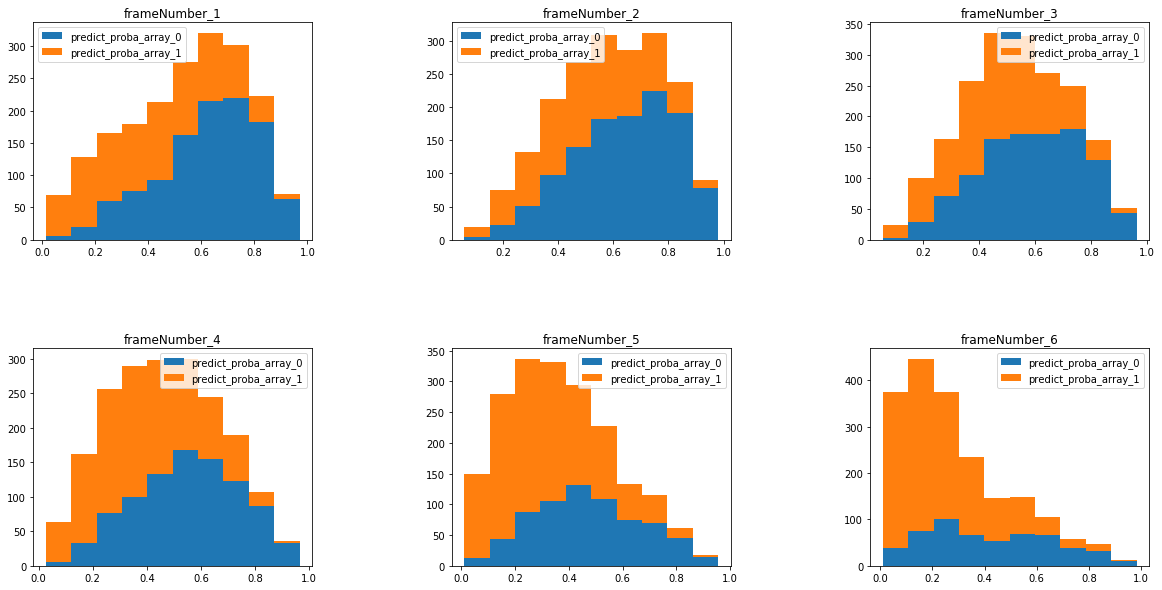

In [5]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [6]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.735563    0.575904    0.538442    0.702614    0.092714    0.176861   
1       0.821243    0.758600    0.312601    0.651035    0.191361    0.137632   
2       0.313204    0.906790    0.532471    0.799448    0.133487    0.054346   
3       0.849604    0.854872    0.107500    0.205853    0.518357    0.286335   
4       0.619193    0.739027    0.303112    0.744262    0.095703    0.247069   
5       0.051013    0.333400    0.799355    0.807805    0.271677    0.329354   
6       0.330467    0.632949    0.704547    0.752837    0.221851    0.127763   
7       0.676826    0.359529    0.613228    0.556974    0.138702    0.484612   
8       0.495021    0.327194    0.448745    0.724908    0.700244    0.077732   
9       0.426754    0.434352    0.305793    0.455690    0.557441    0.628198   
10      0.189298    0.826759    0.552604    0.788028    0.526449    0.024284   
11      0.629692    0.181540    0.513512

In [7]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7488584474885844, 回収率は0.9893835616438356
確率0.7以上で1に単勝betした場合、的中率は0.775092936802974, 回収率は0.9879182156133829
確率0.8以上で1に単勝betした場合、的中率は0.8608695652173913, 回収率は1.0126086956521738


In [8]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-2560, 回収率は0.9735810113519092
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は5030, 回収率は1.0815235008103727
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-680, 回収率は0.9797619047619047
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は1900, 回収率は1.1557377049180328
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は1580, 回収率は1.023939393939394
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は6310, 回収率は1.1502380952380953
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は420, 回収率は1.0188340807174887
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は960, 回収率は1.1170731707317074
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は270, 回収率は1.0068877551020408
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は3320, 回収率は1.1366255144032922
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-30, 回収率は0.9977099236641221
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は530, 回収率は1.1127659574468085


In [9]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-96640, 回収率は0.8840690978886756
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-99610, 回収率は0.7811731107205624
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-20770, 回収率は0.8835762331838565
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-60670, 回収率は0.8770867098865478
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-66100, 回収率は0.7540922619047619
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-9390, 回収率は0.9037909836065574
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-28330, 回収率は0.8542695473251029
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-31360, 回収率は0.7007633587786259
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-7900, 回収率は0.7898936170212766


In [10]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-81000, 回収率は0.935489009238611
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-35580, 回収率は0.9606067316209035
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は19550, 回収率は1.0339409722222221
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-31340, 回収率は0.9025497512437811
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は4260, 回収率は1.03328125
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-87220, 回収率は0.9054013015184382
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-23950, 回収率は0.9637560532687651
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は24730, 回収率は1.0593330134357006
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-17480, 回収率は0.9231985940246046
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は7180, 回収率は1.080493273542601
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-72510, 回収率は0.866316371681416
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-46440, 回収率は0.8801857585139319
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-14590, 回収率は0.9408833063209077
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-25490, 回収率は0.8103422619047619
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は170, 回収率は1.0034836065573771
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-29730, 回収率

In [11]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は90, 回収率は1.0002753977968177
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-7620, 回収率は0.9722303206997085
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-180, 回収率は0.9980263157894737
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-12510, 回収率は0.9351141078838174
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-4140, 回収率は0.9768456375838926
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-4990, 回収率は0.9212933753943218
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-8600, 回収率は0.8853333333333333
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-8380, 回収率は0.8914507772020726
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-3620, 回収率は0.8743055555555556


In [12]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-117360, 回収率は0.8842831788601854
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-35690, 回収率は0.9388241343846417
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-2210, 回収率は0.9915841584158416
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は2400, 回収率は1.0275862068965518
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は1990, 回収率は1.0904545454545456
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-750, 回収率は0.625
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-86680, 回収率は0.8829281469475959
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-30940, 回収率は0.925767754318618
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は4080, 回収率は1.0220064724919093
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は9520, 回収率は1.158139534883721
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は1970, 回収率は1.1515384615384616
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-1000, 回収率は0.0
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-46260, 回収率は0.8935082872928177
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-26760, 回収率は0.8836521739130435
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-8770, 回収率は0.9126494023904382
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は2200, 回収率は1.0662650602409638
p1が0.7

In [13]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は470, 回収率は1.0010208514335361
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は27110, 回収率は1.0823511543134872
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は20140, 回収率は1.0935004642525534
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は19040, 回収率は1.158139534883721
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-10580, 回収率は0.9549019607843138
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は6000, 回収率は1.0365853658536586
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は3580, 回収率は1.0332096474953618
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は5520, 回収率は1.0968421052631578
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は3940, 回収率は1.1515384615384616
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-560, 回収率は0.9932530120481927
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-50, 回収率は0.9991610738255033
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-4270, 回収率は0.8820441988950276
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-950, 回収率は0.9447674418604651
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-500, 回収率は0.9305555555555556
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単

In [14]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-7260, 回収率は0.9040951122853369
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-6060, 回収率は0.8758196721311475
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-5450, 回収率は0.7476851851851852
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-5170, 回収率は0.8674358974358974
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1880, 回収率は0.9229508196721311
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2260, 回収率は0.788785046728972
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-5840, 回収率は0.7673306772908367
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2360, 回収率は0.8515723270440252
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1990, 回収率は0.6938461538461539
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1340, 回収率は0.8759259259259259
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-820, 回収率は0.8757575757575757
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1040, 回収率は0.6285714285714286


In [15]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は470, 回収率は1.0010208514335361
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は27110, 回収率は1.0823511543134872
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は20140, 回収率は1.0935004642525534
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は19040, 回収率は1.158139534883721
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-10580, 回収率は0.9549019607843138
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は6000, 回収率は1.0365853658536586
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は3580, 回収率は1.0332096474953618
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は5520, 回収率は1.0968421052631578
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は3940, 回収率は1.1515384615384616
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-560, 回収率は0.9932530120481927
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-50, 回収率は0.9991610738255033
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-4270, 回収率は0.8820441988950276
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-950, 回収率は0.9447674418604651
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-500, 回収率は0.9305555555555556
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単

In [16]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-4110, 回収率は0.9299829642248723
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は6530, 回収率は1.1920588235294118
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は1170, 回収率は1.0860294117647058
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-9930, 回収率は0.6667785234899329
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は1390, 回収率は1.0858024691358024
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は350, 回収率は1.0555555555555556
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-5870, 回収率は0.6547058823529411
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は530, 回収率は1.0557894736842106
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は1440, 回収率は1.45
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1280, 回収率は0.8
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は220, 回収率は1.0578947368421052
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は450, 回収率は1.45


In [17]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-16130, 回収率は0.6150357995226731
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-3800, 回収率は0.8207547169811321
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3090, 回収率は0.5767123287671233
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-10630, 回収率は0.4685
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-4970, 回収率は0.48762886597938143
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-400, 回収率は0.8518518518518519
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-6070, 回収率は0.45803571428571427
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1600, 回収率は0.6862745098039216
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は1300, 回収率は2.3
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1040, 回収率は0.7333333333333333
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-470, 回収率は0.7235294117647059
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は930, 回収率は4.1


In [18]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-850, 回収率は0.9887714663143989
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は550, 回収率は1.0112704918032787
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は2400, 回収率は1.1111111111111112
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は2170, 回収率は1.0556410256410256
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は730, 回収率は1.0299180327868853
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は2660, 回収率は1.2485981308411216
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-80, 回収率は0.9968127490039841
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-830, 回収率は0.9477987421383648
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は1240, 回収率は1.1907692307692308
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は2380, 回収率は1.2203703703703703
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は410, 回収率は1.062121212121212
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は510, 回収率は1.1821428571428572


In [19]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1 > 0.3、p2 > 0.6, p3 > 0.2で3連単2-1-i にbetすると収益は-20480, 回収率は0.9093805309734513
p1 > 0.3、p2 > 0.6, p3 > 0.3で3連単2-1-i にbetすると収益は-9000, 回収率は0.9482758620689655
p1 > 0.3、p2 > 0.6, p3 > 0.4で3連単2-1-i にbetすると収益は-970, 回収率は0.9922832140015911
p1 > 0.3、p2 > 0.6, p3 > 0.5で3連単2-1-i にbetすると収益は-1030, 回収率は0.9875453446191051
p1 > 0.3、p2 > 0.6, p3 > 0.6で3連単2-1-i にbetすると収益は13100, 回収率は1.2841648590021693
p1 > 0.3、p2 > 0.7, p3 > 0.2で3連単2-1-i にbetすると収益は-14150, 回収率は0.8997165131112687
p1 > 0.3、p2 > 0.7, p3 > 0.3で3連単2-1-i にbetすると収益は-4450, 回収率は0.9580188679245283
p1 > 0.3、p2 > 0.7, p3 > 0.4で3連単2-1-i にbetすると収益は-5990, 回収率は0.9201333333333334
p1 > 0.3、p2 > 0.7, p3 > 0.5で3連単2-1-i にbetすると収益は1600, 回収率は1.0323232323232323
p1 > 0.3、p2 > 0.7, p3 > 0.6で3連単2-1-i にbetすると収益は6530, 回収率は1.2383211678832118
p1 > 0.3、p2 > 0.8, p3 > 0.2で3連単2-1-i にbetすると収益は-15260, 回収率は0.742664418212479
p1 > 0.3、p2 > 0.8, p3 > 0.3で3連単2-1-i にbetすると収益は-21930, 回収率は0.4864168618266979
p1 > 0.3、p2 > 0.8, p3 > 0.4で3連単2-1-i にbetすると収益は-19960, 回収率は0.360256410256410

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す